In [1]:
import os
import numpy as np
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pydicom



In [6]:
import os
import pydicom
import numpy as np
from skimage.transform import resize

def load_dicom_images_from_directory(directory, target_shape=(224, 224), hu_min=-1000, hu_max=400):
    images = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".dcm"):
                dicom_file = pydicom.dcmread(os.path.join(root, filename))
                image = dicom_file.pixel_array.astype(np.float32)
                
                # Hounsfield Unit (HU) normalization
                slope = dicom_file.RescaleSlope if hasattr(dicom_file, 'RescaleSlope') else 1.0
                intercept = dicom_file.RescaleIntercept if hasattr(dicom_file, 'RescaleIntercept') else 0.0
                image = image * slope + intercept
                
                # Clip values to HU range
                image = np.clip(image, hu_min, hu_max)
                
                # Normalize to [0, 1]
                image = (image - hu_min) / (hu_max - hu_min)
                
                # Resize image
                image = resize(image, target_shape, anti_aliasing=True)
                
                images.append(image)
    return np.array(images, dtype=np.float32)


In [7]:
hu_min = -1000
hu_max = 400

In [8]:
benign_dir = "/Volumes/One Touch/Example/BENIGN"
malignant_dir = "/Volumes/One Touch/Example/MALIGNANT"
# Load DICOM images from "benign" and "malignant" directories
benign_images = load_dicom_images_from_directory(benign_dir)
malignant_images = load_dicom_images_from_directory(malignant_dir)



In [9]:
benign_labels = np.zeros(len(benign_images))  # 0 for benign
malignant_labels = np.ones(len(malignant_images))  # 1 for malignant

print(len(benign_images))
print(len(malignant_images))



25160
25680


In [10]:
# Combine images and labels
images = np.concatenate((benign_images, malignant_images), axis=0)
labels = np.concatenate((benign_labels, malignant_labels), axis=0)



In [12]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)



In [13]:
print(len(X_test))
print(len(X_val))
print(len(X_train))

1017
9151
40672


In [9]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pydicom
from skimage.transform import resize

# Load pre-trained ResNet50 model
base_model = ResNet50(weights=None , include_top=False, input_shape=(224, 224, 1))
base_model.trainable = False

# Add custom layers on top of the ResNet50 base model
model_res50 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_res50.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)



In [10]:
model_res50.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# Train the model
model_history = model_res50.fit(X_train, y_train, epochs=500, steps_per_epoch = 10, batch_size = 32)

Epoch 1/500
10/10 [==============================] - 10s 747ms/step - loss: 0.7892 - accuracy: 0.6156
Epoch 2/500
10/10 [==============================] - 7s 711ms/step - loss: 0.6041 - accuracy: 0.6750
Epoch 3/500
10/10 [==============================] - 7s 709ms/step - loss: 0.5750 - accuracy: 0.7031
Epoch 4/500
10/10 [==============================] - 7s 693ms/step - loss: 0.5758 - accuracy: 0.7250
Epoch 5/500
10/10 [==============================] - 7s 699ms/step - loss: 0.5351 - accuracy: 0.7563
Epoch 6/500
10/10 [==============================] - 7s 698ms/step - loss: 0.5494 - accuracy: 0.7312
Epoch 7/500
10/10 [==============================] - 7s 691ms/step - loss: 0.5167 - accuracy: 0.7469
Epoch 8/500
10/10 [==============================] - 7s 684ms/step - loss: 0.5198 - accuracy: 0.7406
Epoch 9/500
10/10 [==============================] - 7s 677ms/step - loss: 0.6696 - accuracy: 0.6625
Epoch 10/500
10/10 [==============================] - 7s 682ms/step - loss: 0.5752 - accur

10/10 [==============================] - 7s 696ms/step - loss: 0.3028 - accuracy: 0.8500
Epoch 161/500
10/10 [==============================] - 7s 696ms/step - loss: 0.2584 - accuracy: 0.9000
Epoch 162/500
10/10 [==============================] - 7s 721ms/step - loss: 0.3612 - accuracy: 0.8281
Epoch 163/500
10/10 [==============================] - 8s 759ms/step - loss: 0.3363 - accuracy: 0.8531
Epoch 164/500
10/10 [==============================] - 7s 691ms/step - loss: 0.3648 - accuracy: 0.8594
Epoch 165/500
10/10 [==============================] - 7s 699ms/step - loss: 0.4004 - accuracy: 0.7969
Epoch 166/500
10/10 [==============================] - 7s 694ms/step - loss: 0.3434 - accuracy: 0.8500
Epoch 167/500
10/10 [==============================] - 7s 698ms/step - loss: 0.3378 - accuracy: 0.8375
Epoch 168/500
10/10 [==============================] - 7s 699ms/step - loss: 0.2798 - accuracy: 0.8938
Epoch 169/500
10/10 [==============================] - 7s 706ms/step - loss: 0.2871 - a

10/10 [==============================] - 7s 686ms/step - loss: 0.2156 - accuracy: 0.9312
Epoch 319/500
10/10 [==============================] - 7s 690ms/step - loss: 0.2214 - accuracy: 0.9031
Epoch 320/500
10/10 [==============================] - 7s 693ms/step - loss: 0.2178 - accuracy: 0.9125
Epoch 321/500
10/10 [==============================] - 7s 682ms/step - loss: 0.2075 - accuracy: 0.9312
Epoch 322/500
10/10 [==============================] - 7s 694ms/step - loss: 0.1942 - accuracy: 0.9219
Epoch 323/500
10/10 [==============================] - 7s 688ms/step - loss: 0.2248 - accuracy: 0.9031
Epoch 324/500
10/10 [==============================] - 7s 690ms/step - loss: 0.2717 - accuracy: 0.8750
Epoch 325/500
10/10 [==============================] - 7s 704ms/step - loss: 0.2752 - accuracy: 0.8875
Epoch 326/500
10/10 [==============================] - 7s 688ms/step - loss: 0.1812 - accuracy: 0.9500
Epoch 327/500
10/10 [==============================] - 7s 695ms/step - loss: 0.2347 - a

10/10 [==============================] - 7s 678ms/step - loss: 0.1816 - accuracy: 0.9281
Epoch 477/500
10/10 [==============================] - 7s 682ms/step - loss: 0.1315 - accuracy: 0.9594
Epoch 478/500
10/10 [==============================] - 7s 680ms/step - loss: 0.1366 - accuracy: 0.9469
Epoch 479/500
10/10 [==============================] - 7s 686ms/step - loss: 0.1348 - accuracy: 0.9656
Epoch 480/500
10/10 [==============================] - 7s 687ms/step - loss: 0.1258 - accuracy: 0.9500
Epoch 481/500
10/10 [==============================] - 7s 689ms/step - loss: 0.1177 - accuracy: 0.9656
Epoch 482/500
10/10 [==============================] - 7s 677ms/step - loss: 0.1037 - accuracy: 0.9625
Epoch 483/500
10/10 [==============================] - 7s 680ms/step - loss: 0.1167 - accuracy: 0.9594
Epoch 484/500
10/10 [==============================] - 7s 681ms/step - loss: 0.1263 - accuracy: 0.9531
Epoch 485/500
10/10 [==============================] - 7s 679ms/step - loss: 0.1247 - a

In [12]:
# Evaluate the model on the test set
evaluation = model_res50.evaluate(X_val, y_val)

# Print the evaluation results (loss and accuracy)
print(f"VAL Loss: {evaluation[0]}")
print(f"VAL Accuracy: {evaluation[1]}")

286/286 [==============================] - 185s 644ms/step - loss: 0.1563 - accuracy: 0.9440
VAL Loss: 0.15634731948375702
VAL Accuracy: 0.9440498352050781


In [13]:
# Evaluate the model on the test set
evaluation = model_res50.evaluate(X_test, y_test)

# Print the evaluation results (loss and accuracy)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


32/32 [==============================] - 21s 647ms/step - loss: 0.1560 - accuracy: 0.9489
Test Loss: 0.1560440957546234
Test Accuracy: 0.9488692283630371


32/32 [==============================] - 23s 659ms/step


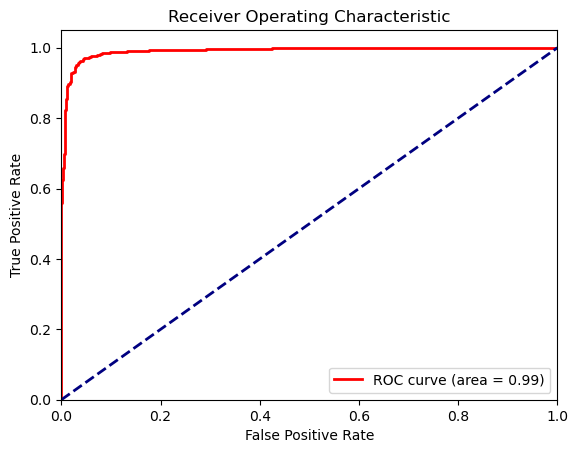

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = model_res50.predict(X_test)
#positive_class = predictions[:, 1]
#y_test = y_test[:len(predictions)]
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### print(np.mean(fpr))
print(np.mean(tpr))

32/32 [==============================] - 21s 642ms/step


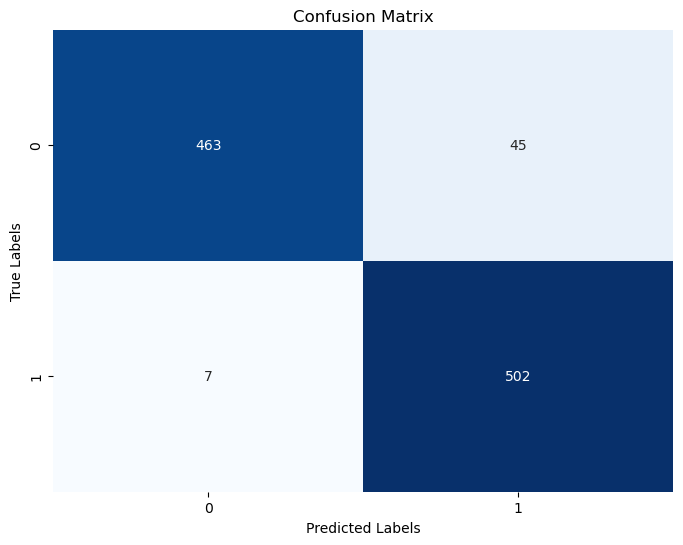

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions on the test set
y_pred =model_res50.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [16]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pydicom
from skimage.transform import resize

# Load pre-trained ResNet50 model
base_model = ResNet50V2(weights=None , include_top=False, input_shape=(224, 224, 1))
base_model.trainable = False

# Add custom layers on top of the ResNet50 base model
model_res50V = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_res50V.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)



In [17]:
model_res50V.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
# Train the model
model_history = model_res50V.fit(X_train, y_train, epochs=500, steps_per_epoch = 10, batch_size = 32)

Epoch 1/500
10/10 [==============================] - 8s 611ms/step - loss: 0.8280 - accuracy: 0.4719
Epoch 2/500
10/10 [==============================] - 6s 589ms/step - loss: 0.6544 - accuracy: 0.6594
Epoch 3/500
10/10 [==============================] - 6s 589ms/step - loss: 0.6065 - accuracy: 0.6719
Epoch 4/500
10/10 [==============================] - 6s 578ms/step - loss: 0.5616 - accuracy: 0.7156
Epoch 5/500
10/10 [==============================] - 6s 581ms/step - loss: 0.5784 - accuracy: 0.7000
Epoch 6/500
10/10 [==============================] - 6s 593ms/step - loss: 0.4923 - accuracy: 0.7688
Epoch 7/500
10/10 [==============================] - 6s 582ms/step - loss: 0.5370 - accuracy: 0.7469
Epoch 8/500
10/10 [==============================] - 6s 596ms/step - loss: 0.5271 - accuracy: 0.7312
Epoch 9/500
10/10 [==============================] - 6s 590ms/step - loss: 0.5403 - accuracy: 0.7500
Epoch 10/500
10/10 [==============================] - 6s 601ms/step - loss: 0.5536 - accura

10/10 [==============================] - 6s 584ms/step - loss: 0.2803 - accuracy: 0.8594
Epoch 161/500
10/10 [==============================] - 6s 582ms/step - loss: 0.2155 - accuracy: 0.9187
Epoch 162/500
10/10 [==============================] - 6s 583ms/step - loss: 0.2124 - accuracy: 0.9438
Epoch 163/500
10/10 [==============================] - 6s 575ms/step - loss: 0.2199 - accuracy: 0.9125
Epoch 164/500
10/10 [==============================] - 6s 576ms/step - loss: 0.2014 - accuracy: 0.9469
Epoch 165/500
10/10 [==============================] - 6s 584ms/step - loss: 0.2306 - accuracy: 0.9094
Epoch 166/500
10/10 [==============================] - 6s 579ms/step - loss: 0.1886 - accuracy: 0.9250
Epoch 167/500
10/10 [==============================] - 6s 579ms/step - loss: 0.1817 - accuracy: 0.9187
Epoch 168/500
10/10 [==============================] - 6s 583ms/step - loss: 0.1884 - accuracy: 0.9406
Epoch 169/500
10/10 [==============================] - 6s 578ms/step - loss: 0.1673 - a

10/10 [==============================] - 6s 574ms/step - loss: 0.1699 - accuracy: 0.9250
Epoch 319/500
10/10 [==============================] - 6s 576ms/step - loss: 0.1713 - accuracy: 0.9312
Epoch 320/500
10/10 [==============================] - 6s 584ms/step - loss: 0.1260 - accuracy: 0.9531
Epoch 321/500
10/10 [==============================] - 6s 575ms/step - loss: 0.1086 - accuracy: 0.9594
Epoch 322/500
10/10 [==============================] - 6s 580ms/step - loss: 0.1186 - accuracy: 0.9563
Epoch 323/500
10/10 [==============================] - 6s 588ms/step - loss: 0.0916 - accuracy: 0.9750
Epoch 324/500
10/10 [==============================] - 6s 585ms/step - loss: 0.1435 - accuracy: 0.9469
Epoch 325/500
10/10 [==============================] - 6s 580ms/step - loss: 0.0853 - accuracy: 0.9750
Epoch 326/500
10/10 [==============================] - 6s 578ms/step - loss: 0.1084 - accuracy: 0.9719
Epoch 327/500
10/10 [==============================] - 6s 580ms/step - loss: 0.0766 - a

10/10 [==============================] - 6s 577ms/step - loss: 0.0605 - accuracy: 0.9812
Epoch 477/500
10/10 [==============================] - 6s 582ms/step - loss: 0.0585 - accuracy: 0.9875
Epoch 478/500
10/10 [==============================] - 6s 575ms/step - loss: 0.0902 - accuracy: 0.9781
Epoch 479/500
10/10 [==============================] - 6s 578ms/step - loss: 0.0626 - accuracy: 0.9750
Epoch 480/500
10/10 [==============================] - 6s 583ms/step - loss: 0.0867 - accuracy: 0.9656
Epoch 481/500
10/10 [==============================] - 6s 579ms/step - loss: 0.0478 - accuracy: 0.9875
Epoch 482/500
10/10 [==============================] - 6s 584ms/step - loss: 0.0443 - accuracy: 0.9875
Epoch 483/500
10/10 [==============================] - 6s 576ms/step - loss: 0.0823 - accuracy: 0.9812
Epoch 484/500
10/10 [==============================] - 6s 579ms/step - loss: 0.0932 - accuracy: 0.9656
Epoch 485/500
10/10 [==============================] - 6s 585ms/step - loss: 0.0391 - a

In [19]:
# Evaluate the model on the test set
evaluation = model_res50V.evaluate(X_val, y_val)

# Print the evaluation results (loss and accuracy)
print(f"VAL Loss: {evaluation[0]}")
print(f"VAL Accuracy: {evaluation[1]}")
# Evaluate the model on the test set
evaluation = model_res50V.evaluate(X_test, y_test)

# Print the evaluation results (loss and accuracy)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


286/286 [==============================] - 155s 540ms/step - loss: 0.0557 - accuracy: 0.9827
VAL Loss: 0.05565597116947174
VAL Accuracy: 0.9827341437339783
32/32 [==============================] - 17s 538ms/step - loss: 0.0506 - accuracy: 0.9843
Test Loss: 0.050584595650434494
Test Accuracy: 0.9842674732208252


32/32 [==============================] - 19s 574ms/step


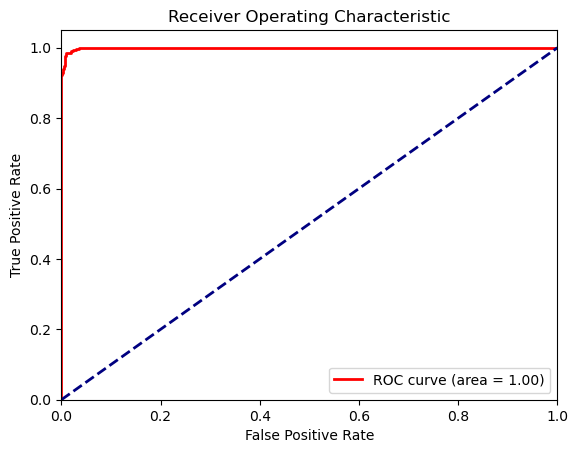

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = model_res50V.predict(X_test)
#positive_class = predictions[:, 1]
#y_test = y_test[:len(predictions)]
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


32/32 [==============================] - 18s 566ms/step


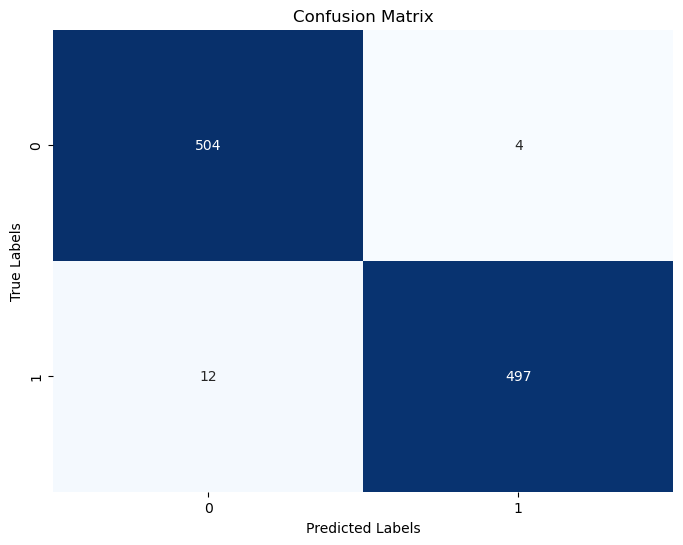

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions on the test set
y_pred =model_res50V.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [8]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pydicom
from skimage.transform import resize

# Load pre-trained ResNet50 model
base_model = ResNet101(weights=None , include_top=False, input_shape=(224, 224, 1))
base_model.trainable = False

# Add custom layers on top of the ResNet50 base model
model_res101 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_res101.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)



In [9]:
import time
model_res101.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
start = time.time()
model_history = model_res101.fit(X_train, y_train, epochs=250, steps_per_epoch = 10, batch_size = 32)
end = time.time()
print(end - start)

Epoch 1/250
10/10 [==============================] - 18s 1s/step - loss: 0.7342 - accuracy: 0.4750
Epoch 2/250
10/10 [==============================] - 12s 1s/step - loss: 0.7195 - accuracy: 0.5031
Epoch 3/250
10/10 [==============================] - 12s 1s/step - loss: 0.6816 - accuracy: 0.5219
Epoch 4/250
10/10 [==============================] - 12s 1s/step - loss: 0.6704 - accuracy: 0.6062
Epoch 5/250
10/10 [==============================] - 12s 1s/step - loss: 0.6458 - accuracy: 0.7250
Epoch 6/250
10/10 [==============================] - 12s 1s/step - loss: 0.6477 - accuracy: 0.6938
Epoch 7/250
10/10 [==============================] - 12s 1s/step - loss: 0.6372 - accuracy: 0.6750
Epoch 8/250
10/10 [==============================] - 12s 1s/step - loss: 0.6357 - accuracy: 0.6625
Epoch 9/250
10/10 [==============================] - 12s 1s/step - loss: 0.6053 - accuracy: 0.7031
Epoch 10/250
10/10 [==============================] - 12s 1s/step - loss: 0.5961 - accuracy: 0.6906
Epoch 11/

10/10 [==============================] - 12s 1s/step - loss: 0.4130 - accuracy: 0.8125
Epoch 84/250
10/10 [==============================] - 12s 1s/step - loss: 0.4670 - accuracy: 0.7812
Epoch 85/250
10/10 [==============================] - 12s 1s/step - loss: 0.3991 - accuracy: 0.8031
Epoch 86/250
10/10 [==============================] - 12s 1s/step - loss: 0.4442 - accuracy: 0.7875
Epoch 87/250
10/10 [==============================] - 12s 1s/step - loss: 0.5200 - accuracy: 0.7594
Epoch 88/250
10/10 [==============================] - 12s 1s/step - loss: 0.4724 - accuracy: 0.7750
Epoch 89/250
10/10 [==============================] - 12s 1s/step - loss: 0.4933 - accuracy: 0.7812
Epoch 90/250
10/10 [==============================] - 12s 1s/step - loss: 0.4105 - accuracy: 0.8219
Epoch 91/250
10/10 [==============================] - 12s 1s/step - loss: 0.3937 - accuracy: 0.7937
Epoch 92/250
10/10 [==============================] - 12s 1s/step - loss: 0.4422 - accuracy: 0.7906
Epoch 93/250


10/10 [==============================] - 12s 1s/step - loss: 0.3541 - accuracy: 0.8687
Epoch 246/250
10/10 [==============================] - 12s 1s/step - loss: 0.3691 - accuracy: 0.8469
Epoch 247/250
10/10 [==============================] - 12s 1s/step - loss: 0.3769 - accuracy: 0.8250
Epoch 248/250
10/10 [==============================] - 13s 1s/step - loss: 0.3409 - accuracy: 0.8719
Epoch 249/250
10/10 [==============================] - 13s 1s/step - loss: 0.3710 - accuracy: 0.8469
Epoch 250/250
10/10 [==============================] - 13s 1s/step - loss: 0.4187 - accuracy: 0.8281


In [10]:
# Evaluate the model on the test set
evaluation = model_res101.evaluate(X_val, y_val)

# Print the evaluation results (loss and accuracy)
print(f"VAL Loss: {evaluation[0]}")
print(f"VAL Accuracy: {evaluation[1]}")
# Evaluate the model on the test set
evaluation = model_res101.evaluate(X_test, y_test)

# Print the evaluation results (loss and accuracy)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


286/286 [==============================] - 336s 1s/step - loss: 0.3755 - accuracy: 0.8382
VAL Loss: 0.3755446672439575
VAL Accuracy: 0.8381597399711609
32/32 [==============================] - 37s 1s/step - loss: 0.3481 - accuracy: 0.8584
Test Loss: 0.3481247127056122
Test Accuracy: 0.8584070801734924


32/32 [==============================] - 41s 1s/step


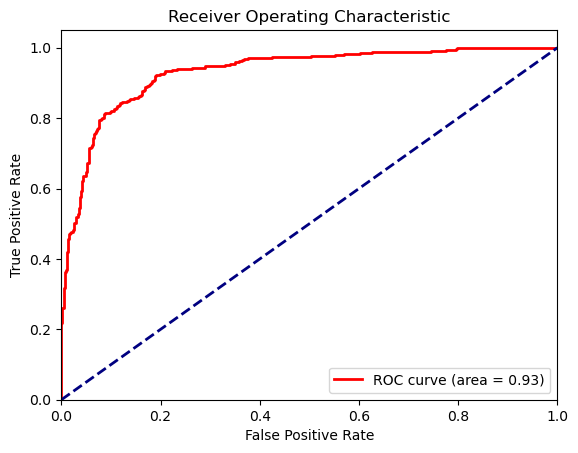

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = model_res101.predict(X_test)
#positive_class = predictions[:, 1]
#y_test = y_test[:len(predictions)]
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


32/32 [==============================] - 37s 1s/step


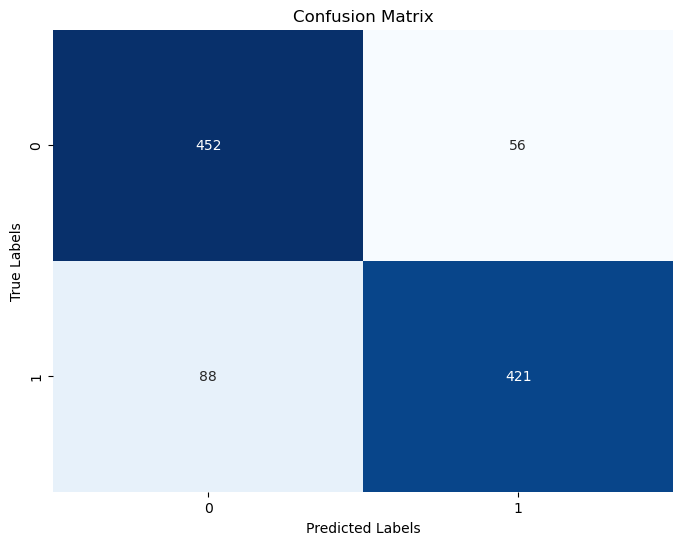

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions on the test set
y_pred =model_res101.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [14]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pydicom
from skimage.transform import resize

# Load pre-trained ResNet50 model
base_model = ResNet101V2(weights=None , include_top=False, input_shape=(224, 224, 1))
base_model.trainable = False

# Add custom layers on top of the ResNet50 base model
model_res101V = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_res101V.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)


In [15]:
import time
model_res101V.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
start = time.time()
model_history = model_res101V.fit(X_train, y_train, epochs=500, steps_per_epoch = 10, batch_size = 32)
end = time.time()
print(end - start)

Epoch 1/500
10/10 [==============================] - 15s 1s/step - loss: 1.0870 - accuracy: 0.5500
Epoch 2/500
10/10 [==============================] - 11s 1s/step - loss: 0.5953 - accuracy: 0.6938
Epoch 3/500
10/10 [==============================] - 11s 1s/step - loss: 0.5916 - accuracy: 0.7312
Epoch 4/500
10/10 [==============================] - 11s 1s/step - loss: 0.6778 - accuracy: 0.6625
Epoch 5/500
10/10 [==============================] - 11s 1s/step - loss: 0.5806 - accuracy: 0.7031
Epoch 6/500
10/10 [==============================] - 11s 1s/step - loss: 0.5745 - accuracy: 0.7094
Epoch 7/500
10/10 [==============================] - 11s 1s/step - loss: 0.5057 - accuracy: 0.7625
Epoch 8/500
10/10 [==============================] - 11s 1s/step - loss: 0.4637 - accuracy: 0.7812
Epoch 9/500
10/10 [==============================] - 11s 1s/step - loss: 0.5600 - accuracy: 0.7250
Epoch 10/500
10/10 [==============================] - 11s 1s/step - loss: 0.5160 - accuracy: 0.7656
Epoch 11/

10/10 [==============================] - 11s 1s/step - loss: 0.3756 - accuracy: 0.8219
Epoch 84/500
10/10 [==============================] - 11s 1s/step - loss: 0.3764 - accuracy: 0.8344
Epoch 85/500
10/10 [==============================] - 11s 1s/step - loss: 0.3566 - accuracy: 0.8438
Epoch 86/500
10/10 [==============================] - 11s 1s/step - loss: 0.3617 - accuracy: 0.8531
Epoch 87/500
10/10 [==============================] - 11s 1s/step - loss: 0.3709 - accuracy: 0.8281
Epoch 88/500
10/10 [==============================] - 11s 1s/step - loss: 0.3259 - accuracy: 0.8438
Epoch 89/500
10/10 [==============================] - 11s 1s/step - loss: 0.3309 - accuracy: 0.8625
Epoch 90/500
10/10 [==============================] - 11s 1s/step - loss: 0.2931 - accuracy: 0.8750
Epoch 91/500
10/10 [==============================] - 11s 1s/step - loss: 0.2677 - accuracy: 0.8844
Epoch 92/500
10/10 [==============================] - 11s 1s/step - loss: 0.3299 - accuracy: 0.8438
Epoch 93/500


10/10 [==============================] - 11s 1s/step - loss: 0.2478 - accuracy: 0.9000
Epoch 246/500
10/10 [==============================] - 10s 1s/step - loss: 0.1191 - accuracy: 0.9656
Epoch 247/500
10/10 [==============================] - 11s 1s/step - loss: 0.1407 - accuracy: 0.9438
Epoch 248/500
10/10 [==============================] - 11s 1s/step - loss: 0.1429 - accuracy: 0.9500
Epoch 249/500
10/10 [==============================] - 11s 1s/step - loss: 0.1060 - accuracy: 0.9688
Epoch 250/500
10/10 [==============================] - 11s 1s/step - loss: 0.1137 - accuracy: 0.9688
Epoch 251/500
10/10 [==============================] - 11s 1s/step - loss: 0.1833 - accuracy: 0.9438
Epoch 252/500
10/10 [==============================] - 11s 1s/step - loss: 0.1346 - accuracy: 0.9531
Epoch 253/500
10/10 [==============================] - 11s 1s/step - loss: 0.1996 - accuracy: 0.9156
Epoch 254/500
10/10 [==============================] - 11s 1s/step - loss: 0.2160 - accuracy: 0.9094
Epoc

10/10 [==============================] - 11s 1s/step - loss: 0.0696 - accuracy: 0.9688
Epoch 408/500
10/10 [==============================] - 11s 1s/step - loss: 0.0834 - accuracy: 0.9719
Epoch 409/500
10/10 [==============================] - 10s 1s/step - loss: 0.0709 - accuracy: 0.9844
Epoch 410/500
10/10 [==============================] - 11s 1s/step - loss: 0.0500 - accuracy: 0.9875
Epoch 411/500
10/10 [==============================] - 11s 1s/step - loss: 0.0924 - accuracy: 0.9688
Epoch 412/500
10/10 [==============================] - 11s 1s/step - loss: 0.0741 - accuracy: 0.9719
Epoch 413/500
10/10 [==============================] - 11s 1s/step - loss: 0.0538 - accuracy: 0.9781
Epoch 414/500
10/10 [==============================] - 11s 1s/step - loss: 0.0529 - accuracy: 0.9844
Epoch 415/500
10/10 [==============================] - 11s 1s/step - loss: 0.1766 - accuracy: 0.9406
Epoch 416/500
10/10 [==============================] - 11s 1s/step - loss: 0.1961 - accuracy: 0.9312
Epoc

In [16]:
# Evaluate the model on the test set
evaluation = model_res101V.evaluate(X_val, y_val)

# Print the evaluation results (loss and accuracy)
print(f"VAL Loss: {evaluation[0]}")
print(f"VAL Accuracy: {evaluation[1]}")
# Evaluate the model on the test set
evaluation = model_res101V.evaluate(X_test, y_test)

# Print the evaluation results (loss and accuracy)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


286/286 [==============================] - 296s 1s/step - loss: 0.0575 - accuracy: 0.9811
VAL Loss: 0.0575239360332489
VAL Accuracy: 0.9810949563980103
32/32 [==============================] - 33s 1s/step - loss: 0.0574 - accuracy: 0.9803
Test Loss: 0.057354725897312164
Test Accuracy: 0.9803343415260315


32/32 [==============================] - 33s 1s/step


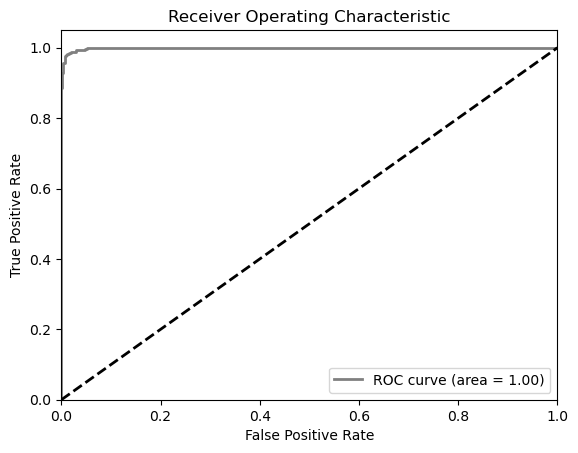

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = model_res101V.predict(X_test)
#positive_class = predictions[:, 1]
#y_test = y_test[:len(predictions)]
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='grey', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


32/32 [==============================] - 34s 1s/step


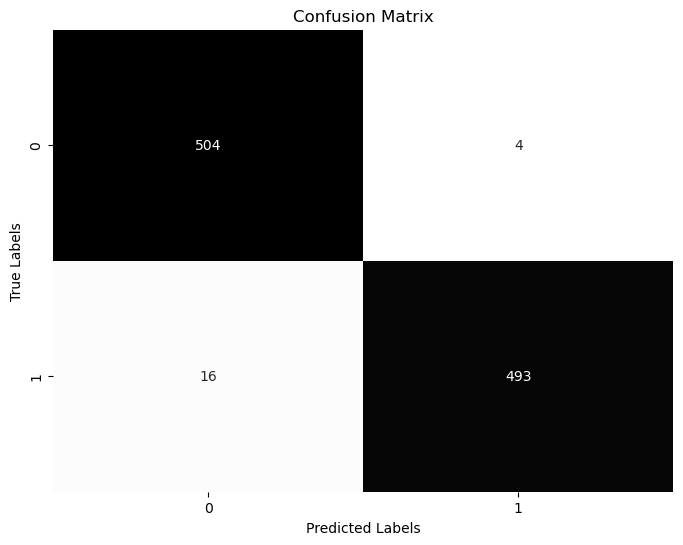

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions on the test set
y_pred =model_res101V.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greys", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [27]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pydicom
from skimage.transform import resize

# Load pre-trained ResNet50 model
base_model = ResNet152(weights=None , include_top=False, input_shape=(224, 224, 1))
base_model.trainable = False

# Add custom layers on top of the ResNet50 base model
model_res152 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid'),
])

# Compile the model
model_res152.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)



In [28]:
import time
model_res152.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
start = time.time()
model_history = model_res152.fit(X_train, y_train, epochs=500, steps_per_epoch = 10, batch_size = 32)
end = time.time()
print(end - start)

KeyboardInterrupt: 

In [10]:
# Evaluate the model on the test set
evaluation = model_res152.evaluate(X_val, y_val)

# Print the evaluation results (loss and accuracy)
print(f"VAL Loss: {evaluation[0]}")
print(f"VAL Accuracy: {evaluation[1]}")
# Evaluate the model on the test set
evaluation = model_res152.evaluate(X_test, y_test)

# Print the evaluation results (loss and accuracy)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


286/286 [==============================] - 496s 2s/step - loss: 0.3887 - accuracy: 0.8455
VAL Loss: 0.3886619806289673
VAL Accuracy: 0.8454813957214355
32/32 [==============================] - 54s 2s/step - loss: 0.3599 - accuracy: 0.8496
Test Loss: 0.35985758900642395
Test Accuracy: 0.8495575189590454


32/32 [==============================] - 56s 2s/step


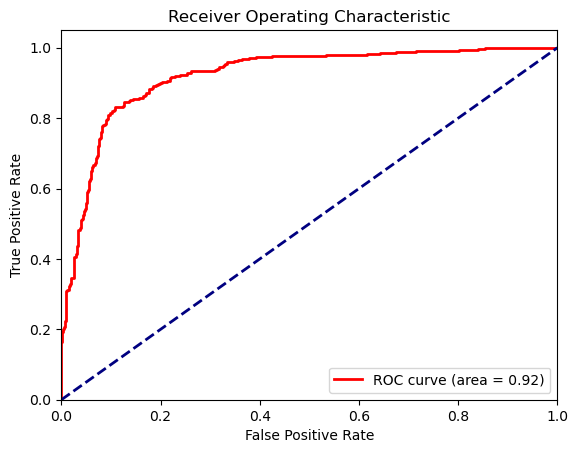

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = model_res152.predict(X_test)
#positive_class = predictions[:, 1]
#y_test = y_test[:len(predictions)]
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [41]:
print(np.mean(fpr))
print(np.mean(tpr))

0.24567203489807676
0.6800517514016005


32/32 [==============================] - 54s 2s/step


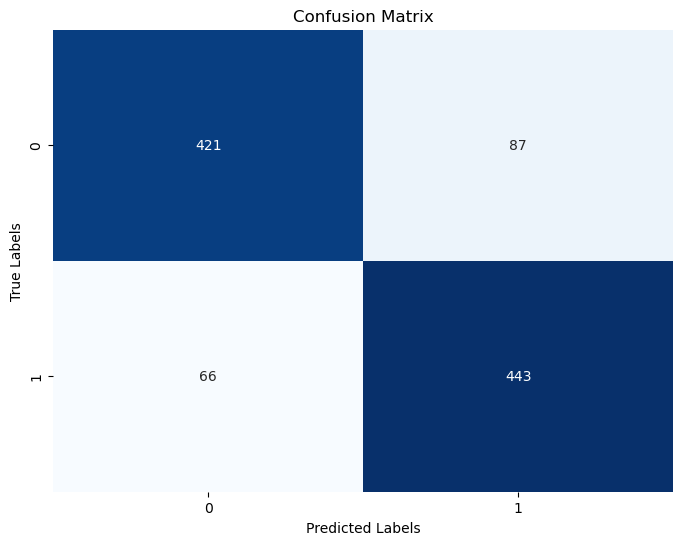

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions on the test set
y_pred =model_res152.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [9]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pydicom
from skimage.transform import resize

# Load pre-trained ResNet50 model
base_model = ResNet152V2(weights=None , include_top=False, input_shape=(224, 224, 1))
base_model.trainable = False

# Add custom layers on top of the ResNet50 base model
model_res152V = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_res152V.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)



In [10]:
import time
model_res152V.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
start = time.time()
model_history = model_res152V.fit(X_train, y_train, epochs=500, steps_per_epoch = 10, batch_size = 32)
end = time.time()
print(end - start)

Epoch 1/500
10/10 [==============================] - 21s 2s/step - loss: 2.0110 - accuracy: 0.5312
Epoch 2/500
10/10 [==============================] - 16s 2s/step - loss: 0.7911 - accuracy: 0.5906
Epoch 3/500
10/10 [==============================] - 16s 2s/step - loss: 0.6126 - accuracy: 0.6938
Epoch 4/500
10/10 [==============================] - 16s 2s/step - loss: 0.5781 - accuracy: 0.7031
Epoch 5/500
10/10 [==============================] - 16s 2s/step - loss: 0.5885 - accuracy: 0.6969
Epoch 6/500
10/10 [==============================] - 16s 2s/step - loss: 0.5679 - accuracy: 0.6969
Epoch 7/500
10/10 [==============================] - 16s 2s/step - loss: 0.5333 - accuracy: 0.7094
Epoch 8/500
10/10 [==============================] - 16s 2s/step - loss: 0.5160 - accuracy: 0.7625
Epoch 9/500
10/10 [==============================] - 16s 2s/step - loss: 0.5236 - accuracy: 0.7594
Epoch 10/500
10/10 [==============================] - 16s 2s/step - loss: 0.5725 - accuracy: 0.7156
Epoch 11/

10/10 [==============================] - 16s 2s/step - loss: 0.3692 - accuracy: 0.8313
Epoch 84/500
10/10 [==============================] - 16s 2s/step - loss: 0.3044 - accuracy: 0.8625
Epoch 85/500
10/10 [==============================] - 16s 2s/step - loss: 0.3477 - accuracy: 0.8438
Epoch 86/500
10/10 [==============================] - 16s 2s/step - loss: 0.2829 - accuracy: 0.8813
Epoch 87/500
10/10 [==============================] - 16s 2s/step - loss: 0.3502 - accuracy: 0.8406
Epoch 88/500
10/10 [==============================] - 16s 2s/step - loss: 0.3148 - accuracy: 0.8719
Epoch 89/500
10/10 [==============================] - 16s 2s/step - loss: 0.2950 - accuracy: 0.8719
Epoch 90/500
10/10 [==============================] - 16s 2s/step - loss: 0.3033 - accuracy: 0.8875
Epoch 91/500
10/10 [==============================] - 16s 2s/step - loss: 0.2788 - accuracy: 0.8750
Epoch 92/500
10/10 [==============================] - 16s 2s/step - loss: 0.2809 - accuracy: 0.8906
Epoch 93/500


10/10 [==============================] - 16s 2s/step - loss: 0.1564 - accuracy: 0.9406
Epoch 246/500
10/10 [==============================] - 16s 2s/step - loss: 0.1311 - accuracy: 0.9625
Epoch 247/500
10/10 [==============================] - 16s 2s/step - loss: 0.1385 - accuracy: 0.9563
Epoch 248/500
10/10 [==============================] - 16s 2s/step - loss: 0.1976 - accuracy: 0.9250
Epoch 249/500
10/10 [==============================] - 16s 2s/step - loss: 0.1744 - accuracy: 0.9250
Epoch 250/500
10/10 [==============================] - 16s 2s/step - loss: 0.1612 - accuracy: 0.9438
Epoch 251/500
10/10 [==============================] - 16s 2s/step - loss: 0.1340 - accuracy: 0.9563
Epoch 252/500
10/10 [==============================] - 16s 2s/step - loss: 0.1331 - accuracy: 0.9563
Epoch 253/500
10/10 [==============================] - 16s 2s/step - loss: 0.1647 - accuracy: 0.9375
Epoch 254/500
10/10 [==============================] - 16s 2s/step - loss: 0.1550 - accuracy: 0.9469
Epoc

10/10 [==============================] - 16s 2s/step - loss: 0.1809 - accuracy: 0.9250
Epoch 408/500
10/10 [==============================] - 16s 2s/step - loss: 0.2113 - accuracy: 0.9000
Epoch 409/500
10/10 [==============================] - 16s 2s/step - loss: 0.3068 - accuracy: 0.8719
Epoch 410/500
10/10 [==============================] - 16s 2s/step - loss: 0.3092 - accuracy: 0.8813
Epoch 411/500
10/10 [==============================] - 16s 2s/step - loss: 0.3932 - accuracy: 0.8469
Epoch 412/500
10/10 [==============================] - 16s 2s/step - loss: 0.2136 - accuracy: 0.9156
Epoch 413/500
10/10 [==============================] - 16s 2s/step - loss: 0.0770 - accuracy: 0.9688
Epoch 414/500
10/10 [==============================] - 16s 2s/step - loss: 0.0898 - accuracy: 0.9781
Epoch 415/500
10/10 [==============================] - 16s 2s/step - loss: 0.0831 - accuracy: 0.9719
Epoch 416/500
10/10 [==============================] - 16s 2s/step - loss: 0.1119 - accuracy: 0.9594
Epoc

In [11]:
# Evaluate the model on the test set
evaluation = model_res152V.evaluate(X_val, y_val)

# Print the evaluation results (loss and accuracy)
print(f"VAL Loss: {evaluation[0]}")
print(f"VAL Accuracy: {evaluation[1]}")
# Evaluate the model on the test set
evaluation = model_res152V.evaluate(X_test, y_test)

# Print the evaluation results (loss and accuracy)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


286/286 [==============================] - 444s 2s/step - loss: 0.0523 - accuracy: 0.9860
VAL Loss: 0.05234900116920471
VAL Accuracy: 0.9860124588012695
32/32 [==============================] - 49s 2s/step - loss: 0.0536 - accuracy: 0.9803
Test Loss: 0.053633902221918106
Test Accuracy: 0.9803343415260315


32/32 [==============================] - 50s 2s/step


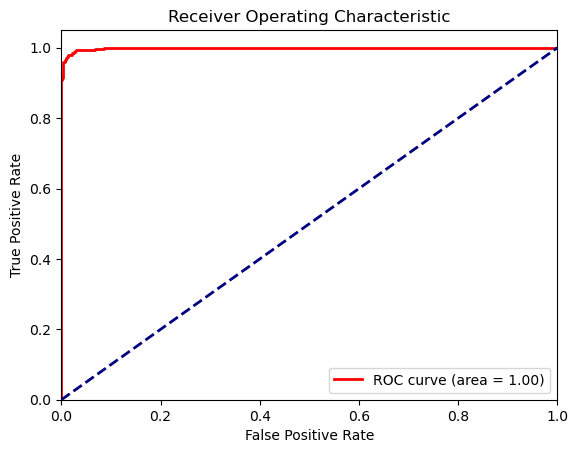

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = model_res152V.predict(X_test)
#positive_class = predictions[:, 1]
#y_test = y_test[:len(predictions)]
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


32/32 [==============================] - 52s 2s/step


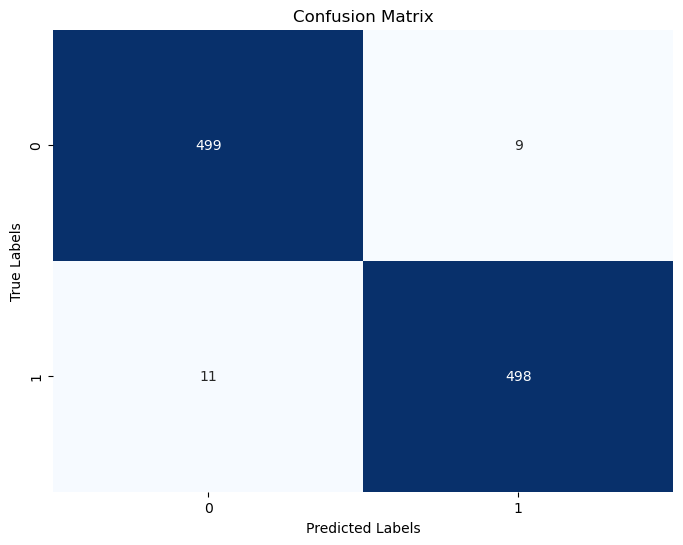

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions on the test set
y_pred =model_res152V.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [10]:
from keras.layers import Dropout
# Import necessary libraries
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pydicom
from skimage.transform import resize
model = Sequential([
    # First Convolutional Layer
    Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(224,224,1)),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    # Second Convolutional Layer
    Conv2D(256, (5,5), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    # Third Convolutional Layer
    Conv2D(384, (3,3), padding="same", activation='relu'),
    
    # Fourth Convolutional Layer
    Conv2D(384, (3,3), padding="same", activation='relu'),
    
    # Fifth Convolutional Layer
    Conv2D(256, (3,3), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    
    # Flatten the feature maps
    Flatten(),
    
    # Fully Connected Layers
    Dense(4096, activation='relu'),
    Dropout(0.3),
    
    Dense(4096, activation='relu'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid') 
])

In [11]:
import time
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
start = time.time()
model_history = model.fit(X_train, y_train, epochs=500, steps_per_epoch = 10, batch_size = 32)
end = time.time()
print(end - start)

Epoch 1/500
10/10 [==============================] - 7s 470ms/step - loss: 0.9297 - accuracy: 0.4812
Epoch 2/500
10/10 [==============================] - 5s 455ms/step - loss: 0.6932 - accuracy: 0.5188
Epoch 3/500
10/10 [==============================] - 5s 458ms/step - loss: 0.6960 - accuracy: 0.4875
Epoch 4/500
10/10 [==============================] - 5s 463ms/step - loss: 0.6932 - accuracy: 0.4938
Epoch 5/500
10/10 [==============================] - 5s 459ms/step - loss: 0.6934 - accuracy: 0.4844
Epoch 6/500
10/10 [==============================] - 5s 457ms/step - loss: 0.6928 - accuracy: 0.5281
Epoch 7/500
10/10 [==============================] - 5s 467ms/step - loss: 0.6939 - accuracy: 0.4938
Epoch 8/500
10/10 [==============================] - 5s 458ms/step - loss: 0.6912 - accuracy: 0.5469
Epoch 9/500
10/10 [==============================] - 5s 465ms/step - loss: 0.6932 - accuracy: 0.5125
Epoch 10/500
10/10 [==============================] - 5s 457ms/step - loss: 0.6924 - accura

10/10 [==============================] - 5s 460ms/step - loss: 0.6926 - accuracy: 0.5375
Epoch 161/500
10/10 [==============================] - 5s 462ms/step - loss: 0.6937 - accuracy: 0.4781
Epoch 162/500
10/10 [==============================] - 5s 462ms/step - loss: 0.6931 - accuracy: 0.4969
Epoch 163/500
10/10 [==============================] - 5s 461ms/step - loss: 0.6927 - accuracy: 0.5406
Epoch 164/500
10/10 [==============================] - 5s 465ms/step - loss: 0.6922 - accuracy: 0.5531
Epoch 165/500
10/10 [==============================] - 5s 462ms/step - loss: 0.6929 - accuracy: 0.5156
Epoch 166/500
10/10 [==============================] - 5s 470ms/step - loss: 0.6930 - accuracy: 0.5063
Epoch 167/500
10/10 [==============================] - 5s 467ms/step - loss: 0.6932 - accuracy: 0.4938
Epoch 168/500
10/10 [==============================] - 5s 465ms/step - loss: 0.6924 - accuracy: 0.5344
Epoch 169/500
10/10 [==============================] - 5s 468ms/step - loss: 0.6934 - a

10/10 [==============================] - 5s 465ms/step - loss: 0.6933 - accuracy: 0.5125
Epoch 319/500
10/10 [==============================] - 5s 460ms/step - loss: 0.6933 - accuracy: 0.4844
Epoch 320/500
10/10 [==============================] - 5s 462ms/step - loss: 0.6931 - accuracy: 0.4906
Epoch 321/500
10/10 [==============================] - 5s 468ms/step - loss: 0.6931 - accuracy: 0.5125
Epoch 322/500
10/10 [==============================] - 5s 464ms/step - loss: 0.6935 - accuracy: 0.4437
Epoch 323/500
10/10 [==============================] - 5s 462ms/step - loss: 0.6932 - accuracy: 0.5063
Epoch 324/500
10/10 [==============================] - 5s 466ms/step - loss: 0.6928 - accuracy: 0.5156
Epoch 325/500
10/10 [==============================] - 5s 460ms/step - loss: 0.6927 - accuracy: 0.5250
Epoch 326/500
10/10 [==============================] - 5s 465ms/step - loss: 0.6936 - accuracy: 0.4844
Epoch 327/500
10/10 [==============================] - 5s 465ms/step - loss: 0.6933 - a

10/10 [==============================] - 5s 466ms/step - loss: 0.6922 - accuracy: 0.5406
Epoch 477/500
10/10 [==============================] - 5s 454ms/step - loss: 0.6928 - accuracy: 0.5219
Epoch 478/500
10/10 [==============================] - 5s 462ms/step - loss: 0.6920 - accuracy: 0.5437
Epoch 479/500
10/10 [==============================] - 5s 469ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 480/500
10/10 [==============================] - 5s 460ms/step - loss: 0.6921 - accuracy: 0.5312
Epoch 481/500
10/10 [==============================] - 5s 466ms/step - loss: 0.6919 - accuracy: 0.5344
Epoch 482/500
10/10 [==============================] - 5s 463ms/step - loss: 0.6939 - accuracy: 0.4844
Epoch 483/500
10/10 [==============================] - 5s 472ms/step - loss: 0.6935 - accuracy: 0.4969
Epoch 484/500
10/10 [==============================] - 5s 467ms/step - loss: 0.6940 - accuracy: 0.4906
Epoch 485/500
10/10 [==============================] - 5s 465ms/step - loss: 0.6931 - a

In [12]:
# Evaluate the model on the test set
evaluation = model.evaluate(X_val, y_val)

# Print the evaluation results (loss and accuracy)
print(f"VAL Loss: {evaluation[0]}")
print(f"VAL Accuracy: {evaluation[1]}")
# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test)

# Print the evaluation results (loss and accuracy)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


286/286 [==============================] - 38s 131ms/step - loss: 0.6930 - accuracy: 0.5072
VAL Loss: 0.6930448412895203
VAL Accuracy: 0.5071576833724976
32/32 [==============================] - 4s 130ms/step - loss: 0.6932 - accuracy: 0.5005
Test Loss: 0.6932488679885864
Test Accuracy: 0.5004916191101074


32/32 [==============================] - 4s 129ms/step


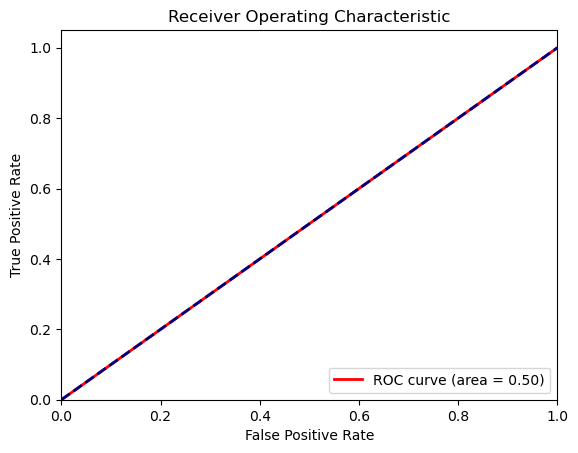

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = model.predict(X_test)
#positive_class = predictions[:, 1]
#y_test = y_test[:len(predictions)]
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


32/32 [==============================] - 4s 128ms/step


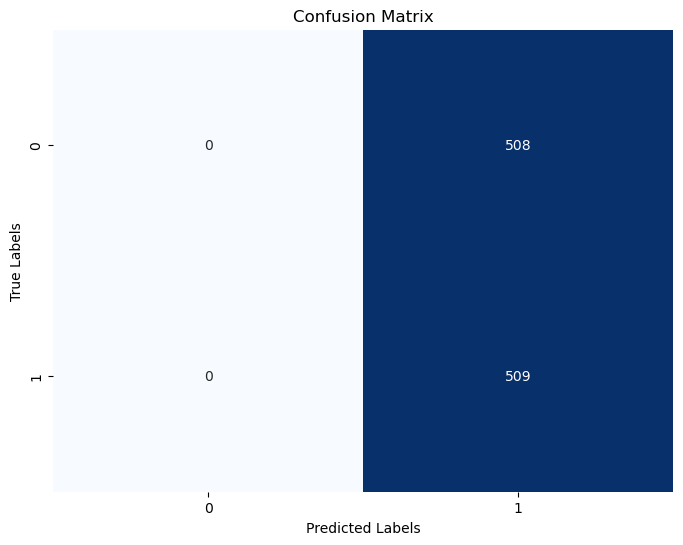

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions on the test set
y_pred =model.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()